In [1]:

%load_ext autoreload
%autoreload 2

In [181]:
from uav_active_sensing.config import PROCESSED_DATA_DIR
from uav_active_sensing.pytorch_dataloaders import TinyImageNetDataset

import random as rd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms.functional import resize

In [3]:
cifar10_processed_dir = PROCESSED_DATA_DIR / "cifar10"

cifar10_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar10_train_dataset = datasets.CIFAR10(
    root=cifar10_processed_dir, train=True, download=False, transform=cifar10_transform
)
cifar10_test_dataset = datasets.CIFAR10(
    root=cifar10_processed_dir, train=False, download=False, transform=cifar10_transform
)

cifar10_train_loader = DataLoader(cifar10_train_dataset, batch_size=1, shuffle=True)
cifar10_test_loader = DataLoader(cifar10_test_dataset, batch_size=1, shuffle=False)

In [4]:

TINY_IMAGENET_PROCESSED_DIR = PROCESSED_DATA_DIR / "tiny_imagenet/tiny-imagenet-200"

tiny_imagenet_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

tiny_imagenet_train_dataset = TinyImageNetDataset(
    root_dir=TINY_IMAGENET_PROCESSED_DIR, split="train", transform=tiny_imagenet_transform
)
tiny_imagenet_val_dataset = TinyImageNetDataset(
    root_dir=TINY_IMAGENET_PROCESSED_DIR, split="val", transform=tiny_imagenet_transform
)

tiny_imagenet_train_loader = DataLoader(tiny_imagenet_train_dataset, batch_size=1, shuffle=True)
tiny_imagenet_val_loader = DataLoader(tiny_imagenet_val_dataset, batch_size=1, shuffle=False)

In [5]:
# Class labels for CIFAR-10
classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Function to visualize images from a batch


def visualize_batch(images, labels, classes, num_samples=1):
    plt.figure(figsize=(12, 5))
    for i in range(num_samples):
        plt.subplot(2, 5, i + 1)
        image = images[i].permute(1, 2, 0).numpy()
        plt.imshow(image)
        plt.title(classes[labels[i].item()])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

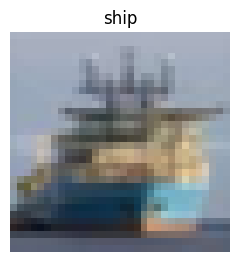

In [6]:
# Get a sample batch from the DataLoader
sample_batch = next(iter(cifar10_train_loader))
images, labels = sample_batch

# Visualize the first 10 images from the batch
visualize_batch(images, labels, classes, num_samples=1)

In [7]:
def visualize_tensors(tensor1, tensor2):
    """
    Visualizes two PyTorch tensors as images side by side.
    If tensors are 3D (e.g., RGB), they will be shown as color images.
    If tensors are 2D, they will be shown as grayscale images.

    Args:
        tensor1 (torch.Tensor): The first tensor to display.
        tensor2 (torch.Tensor): The second tensor to display.
    """
    # Ensure tensors are at least 2D
    if tensor1.dim() < 2 or tensor2.dim() < 2:
        raise ValueError("Tensors must be at least 2D.")

    # If tensors are 3D, check if they represent RGB images (channels last)
    if tensor1.dim() == 3 and tensor1.shape[0] in {3, 1}:  # RGB or grayscale
        tensor1 = tensor1.permute(1, 2, 0)  # Convert (C, H, W) to (H, W, C)
    if tensor2.dim() == 3 and tensor2.shape[0] in {3, 1}:  # RGB or grayscale
        tensor2 = tensor2.permute(1, 2, 0)  # Convert (C, H, W) to (H, W, C)

    # Plot both tensors as images
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # First tensor
    axes[0].imshow(tensor1.numpy())
    axes[0].set_title("Tensor 1")
    axes[0].axis('off')  # Hide axis

    # Second tensor
    axes[1].imshow(tensor2.numpy())
    axes[1].set_title("Tensor 2")
    axes[1].axis('off')  # Hide axis

    plt.show()

In [182]:
class ImageEnv:
    def __init__(
        self, image: torch.Tensor,
        img_FoV_ratio: int,
        device: str = "cpu"
    ) -> None:

        if device is None:
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.device = device
        self.img = image.to(self.device)
        self.img_height, self.img_width = image.shape[1:]

        self.img_sensor_ratio = img_FoV_ratio

        self.sensor_height = self.img_height // self.img_sensor_ratio
        self.sensor_width = self.img_width // self.img_sensor_ratio

        self._sensor_min_pos = [0, 0]
        self.__sensor_pos = [rd.randint(0, self.img_height,), rd.randint(0, self.img_width,)]

        self._min_kernel_size = 1
        self._max_kernel_size = self.img_height - self.sensor_height + 1
        self._max_kernel_size = self._max_kernel_size if self._max_kernel_size % 2 == 1 else self._max_kernel_size - 1
        self.__kernel_size = self._min_kernel_size

        self._sampled_kernel_size_mask = torch.full_like(self.img, fill_value=self._max_kernel_size, dtype=torch.int32)
        self.sampled_img = torch.full_like(self.img, float('nan'), device=self.device)

    @property
    def fov_bbox(self):

        fov_height = int(self.sensor_height + self._kernel_size - 1)
        fov_width = int(self.sensor_width + self._kernel_size - 1)

        top = self._sensor_pos[0]
        left = self._sensor_pos[1]
        bottom = self._sensor_pos[0] + fov_height
        right = self._sensor_pos[1] + fov_width

        return [top, bottom, left, right]

    @property
    def sensor_max_pos(self):
        top, bottom, left, right = self.fov_bbox

        fov_height = bottom - top
        fov_width = right - left
        sensor_max_height = self.img_height - fov_height
        sensor_max_width = self.img_width - fov_width

        return (sensor_max_height, sensor_max_width)

    @property
    def _sensor_pos(self):
        
        return tuple(self.__sensor_pos)

    @_sensor_pos.setter
    def _sensor_pos(self, new_position):
        x, y = new_position
        self.__sensor_pos[0] = max(min(x, self.sensor_max_pos[0]), self._sensor_min_pos[0])
        self.__sensor_pos[1] = max(min(y, self.sensor_max_pos[1]), self._sensor_min_pos[1])

    @property
    def _kernel_size(self):

        return self.__kernel_size
    
    @_kernel_size.setter
    def _kernel_size(self, kernel_size):
        max_kernel_size_from_sensor_pos = min(self.img_height, self.img_width) - max(self._sensor_pos)
        max_kernel_size_from_sensor_pos = max_kernel_size_from_sensor_pos if max_kernel_size_from_sensor_pos % 2 == 1 else max_kernel_size_from_sensor_pos - 1

        self.__kernel_size = max(min(kernel_size, max_kernel_size_from_sensor_pos), self._min_kernel_size)


    def _apply_blur(self, window: torch.Tensor) -> torch.Tensor:
        """
        Applies an averaging blur to the input window tensor while considering margin artifacts.

        Args:
            window (torch.Tensor): A tensor of shape (C, H, W), where C is the number of channels,
                                H is the height, and W is the width of the image.

        Returns:
            torch.Tensor: A blurred tensor with the same shape as the input window.
        """

        padding = self._kernel_size // 2
        window_padded = F.pad(window, (padding, padding, padding, padding), mode='reflect')  # Apply reflection padding to avoid margin artifacts
        blurred = F.avg_pool2d(window_padded.unsqueeze(0), kernel_size=self._kernel_size, stride=1, padding=0).squeeze(0)

        assert blurred.shape == window.shape

        return blurred

    def _filter_high_blur_obs(self, obs: torch.Tensor) -> torch.Tensor:

        top, bottom, left, right = self.fov_bbox

        prev_mask = self._sampled_kernel_size_mask[:, top:bottom, left:right]
        curr_mask = torch.full_like(prev_mask, fill_value=self._kernel_size)

        # Blur mask update
        updated_mask = curr_mask < prev_mask
        self._sampled_kernel_size_mask[:, top:bottom, left:right][updated_mask] = curr_mask[updated_mask]

        # Observation update
        prev_obs = self.sampled_img[:, top:bottom, left:right]
        obs_to_update = curr_mask > prev_mask
        obs[obs_to_update] = prev_obs[obs_to_update]

        return obs

    def _observe(self):
        top, bottom, left, right = self.fov_bbox
        obs = self.img[:, top:bottom, left:right].clone()

        if self._kernel_size > self._min_kernel_size:
            obs = self._apply_blur(obs)
            obs = obs.squeeze(0)

        obs = self._filter_high_blur_obs(obs)


        self.sampled_img[:, top:bottom, left:right] = obs

    def move(self, dx: int, dy: int, dz: int):
        self._sensor_pos = (
            self._sensor_pos[0] + dy,
            self._sensor_pos[1] + dx,
        )
        self._kernel_size += 2 * dz 

        self._observe()

In [183]:
def random_walk(env: ImageEnv, steps: int):
    for _ in range(steps):
        dx = rd.choice([-5, 0, 5])  # Move left, stay, or move right
        dy = rd.choice([-5, 0, 5])  # Move up, stay, or move down
        dz = rd.choice([-5, 0, 5])  # Zoom in, stay, or zoom out

        env.move(dx, dy, dz)

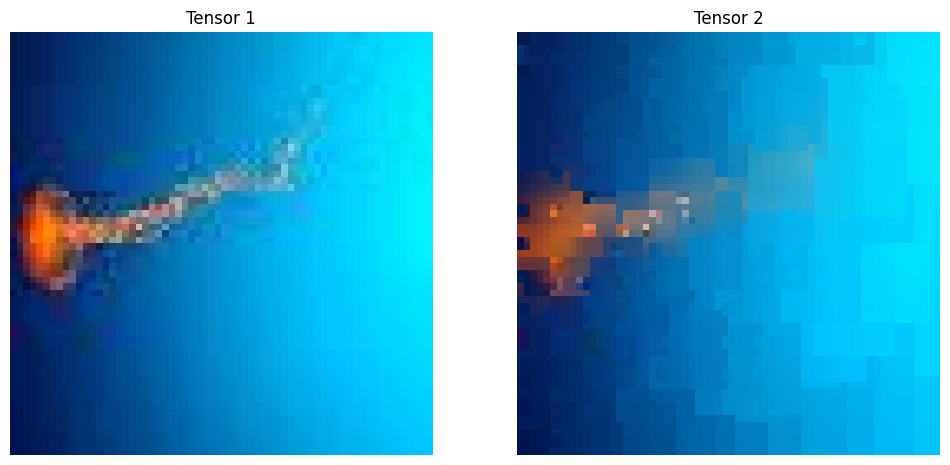

In [193]:
IMG_FOV_RATIO = 32

image, label = tiny_imagenet_train_dataset[15080]
env = ImageEnv(image, IMG_FOV_RATIO)


random_walk(env, 1_000)
visualize_tensors(env.img, env.sampled_img)

In [155]:
def exhaustive_walk(env: ImageEnv):
    """
    Perform an exhaustive walk across all possible states of the ImageEnv.
    This function iterates through every possible position and kernel size.
    
    Args:
        env (ImageEnv): The ImageEnv instance to test.
    """
    # Get the image dimensions
    img_height, img_width = env.img_height, env.img_width



    # Iterate over every possible position
    for y in range(0, img_height - env.sensor_height + 1):
        for x in range(0, img_width - env.sensor_width + 1):
                # Iterate over every possible kernel size
            for kernel_size in range(env._min_kernel_size, env._max_kernel_size + 1, 2):
                # Set the sensor position
                env._sensor_pos = (y, x)

                env._kernel_size = kernel_size

                # Perform the observation
                env._observe()

                # Optional: Print or log the current state for debugging
                # print(f"Kernel Size: {kernel_size}, Position: ({y}, {x})")
                # print(f"Observed Region: {env.sampled_img[:, y:y+env.sensor_height, x:x+env.sensor_width]}")

                # Optional: Add checks or assertions here
                observed_region = env.sampled_img[:, y:y+env.sensor_height, x:x+env.sensor_width]
                assert not torch.isnan(observed_region).any(), "Observed region contains NaN values"
                # assert env.kernel_size == kernel_size, "Kernel size was not set correctly"

In [139]:
# Initialize the environment
image, _ = tiny_imagenet_train_dataset[15080]
env = ImageEnv(image, IMG_FOV_RATIO)

# Perform the exhaustive walk
exhaustive_walk(env)

In [83]:
# TODO: Implement image as environment, following common interface (gymnasium problably)
# TODO: Implement reward model (with pretrained MAE) inside the env mechanics

# Everything nice and decoupled!